In [129]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import numpy as np
import re
import string
import time
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import pandas as pd
import matplotlib.pyplot as plt



'''
MPQA: avg score is 85.0 with n_grams = (4,9) 
feature_trials = [95000,95500, 96000, 96500, 97000, 97500, 98000, 98500]   usually v close to 85 for most these values

tested similar but more n_grams than MR

-----------------------------------------------------------------------------------------------
MR

 did n_grams  4,10  3,10  4,9  5,9  ish
 peaks in  feature_trials grid search: [732500, 779000] 78 < validation acc <78.4
 -------------for n_grams = (5,10)

-----------------------------------------------------------------------------------------------
 SST2
tested ngrams 4,10  3,10  4,11 got 88.9 
best feature_trials = [ 2750000, 2775000, 2800000, 2825000, 2850000] 88.8 < validation acc < 88
best n_gram so far: (4,12)

a

'''

#feature_trials = [95000,95500, 96000, 96500, 97000, 97500, 98000, 98500]
#feature_trials = [40000,50000, 60000,80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000,260000] # wide search
#feature_trials = [435000, 440000, 450000,460000, 470000,480000,  600000, 610000,615000,  620000, 625000, 650000, 675000, 700000,720000, 725000,730000, 735000,740000, 745000, 775000, 780000,785000,790000]
#feature_trials = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 900000,950000]
#feature_trials = [900000, 950000, 1000000, 1050000, 1100000, 1150000, 1200000, 1250000, 1300000, 1350000]
#feature_trials = [ 2750000, 2775000, 2800000, 2825000, 2850000]
#,55000, 60000, 65000]#75000,100000,250000#,500000,600000,750000,1500000]
#feature_trials = [50000,75000,85000, 100000,125000, 150000,175000, 200000,210000, 250000 ,500000,600000]
#feature_trials = [ 23000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 33000,34000,35000,37000,39000,40500,43000,45000]
#feature_trials = [51000, 52000, 53000, 53500, 54000, 54500, 55000,56000, 57000, 58000, 60000, 61000,63000, 65000, 67000, 68000, 70000, 73000, 75000, 77500, 80000, 82500, 85000 ]
#feature_trials = [200000, 210000, 220000,230000, 240000,250000, 260000, 270000, 280000,290000]
#feature_trials = [ 365000, 367500, 370000, 372500, 375000, 377500, 380000, 382500, 385000, 387500, 390000,395000, 400000,405000,410000,420000]
#feature_trials = [400000, 405000, 410000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 460000,470000,480000]



def identity(txt):             # the text is already tokenized, had issues and this made them go away idk
	return txt


def shuffleData(sentences, labels):
	x_train, x_val, y_train, y_val = train_test_split(sentences, labels, shuffle = True, test_size=0.2)  
	# I call this first s.t cross val is done on DIFF split each time.
	
	x_train.extend(x_val) 
	sentences = x_train

	y_train.extend(y_val)
	labels = y_train

	return sentences, labels, (x_val, y_val)




corpus = pd.read_pickle('MPQA.pkl')
sentences, labels = list(corpus.sentence), list(corpus.label)

#note that we do cross validation on a diff ordered dataset each time, run twice to confirm acc ranges.
sentences, labels, (x_val, y_val) = shuffleData(sentences, labels)
skf = StratifiedKFold(n_splits = 10) #10 fold cross validation

	
counts = CountVectorizer(lowercase=True, analyzer='word', dtype=np.float64, ngram_range=(1, 1))
tfidf = TfidfVectorizer(lowercase=True, tokenizer=None, analyzer='word', dtype=np.float64, binary=False, ngram_range=(1, 1))
X = tfidf.fit_transform(sentences)
#X_val = tfidf.transform(x_val)
numFeats = len(tfidf.get_feature_names())
scores = cross_val_score(MultinomialNB(), X, labels, cv = skf, n_jobs = -1) #n_jobs= -1 means program can use all cores, big speed increase. 

val_acc = 100*np.mean(np.abs(scores))  #scores is a list of validation acc's for each fold.
print("accuracy with numFeats: {0}, accuracy = {1}".format(numFeats, val_acc))
#mnb = MultinomialNB()
#mnb.fit(X, labels)
#print(accuracy_score(y_val, mnb.predict(X_val)))


accuracy with numFeats: 6195, accuracy = 84.16945880576321


In [127]:
results = {
    'nb': {
        'time': [],
        'acc': []
    },
    'svm': {
        'time': [],
        'acc': []
    },
    'lr': {
        'time': [],
        'acc': []
    }
}

for x in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000]:
    sentences, labels, (x_val, y_val) = shuffleData(sentences, labels)
    for clf in ['nb', 'svm', 'lr']:
        start = time.time()
        #counts = CountVectorizer(lowercase=True, analyzer='word', dtype=np.float64, ngram_range=(1, 2), binary=True)
        tfidf = TfidfVectorizer(lowercase=True, tokenizer=None, analyzer='word', dtype=np.float64, binary=False, ngram_range=(1, 2), max_features=x)
        X = tfidf.fit_transform(sentences)
        print(len(tfidf.get_feature_names()))
        scores = -1
        if clf == 'nb':
            scores = cross_val_score(MultinomialNB(), X, labels, cv = skf, n_jobs = -1)
        if clf == 'svm':
            scores = cross_val_score(LinearSVC(), X, labels, cv = skf, n_jobs = -1)
        if clf == 'lr':
            scores = cross_val_score(LogisticRegression(), X, labels, cv = skf, n_jobs = -1)
        end = time.time()
        acc = 100*np.mean(np.abs(scores))
        results[clf]['acc'].append(acc)
        results[clf]['time'].append(end - start)
        print('acc: {} time: {}'.format(acc, end - start))
print(results)

1000
acc: 81.52922009691785 time: 3.120556116104126
1000
acc: 81.13307368926363 time: 0.9299168586730957
1000
acc: 81.52942450269883 time: 0.6974577903747559
2000
acc: 84.01823111353043 time: 0.4984569549560547
2000
acc: 84.34828648611375 time: 0.6611530780792236
2000
acc: 83.00928605399321 time: 0.5763647556304932
3000
acc: 84.71576682074378 time: 0.9360702037811279
3000
acc: 85.50754437675126 time: 1.0770461559295654
3000
acc: 83.3865554446034 time: 0.9683310985565186
4000
acc: 84.76330964289251 time: 0.7736160755157471
4000
acc: 85.65912722967992 time: 1.247267246246338
4000
acc: 83.18903757077717 time: 0.9963841438293457
5000
acc: 85.0367348015921 time: 0.6656980514526367
5000
acc: 85.92294951965897 time: 0.7201399803161621
5000
acc: 82.75502212461919 time: 0.6580109596252441
6000
acc: 85.23472346009372 time: 0.5181229114532471
6000
acc: 86.1023637091342 time: 0.6545820236206055
6000
acc: 82.64194786736635 time: 0.5819351673126221
7000
acc: 85.16871241571799 time: 0.507380008697509

In [119]:
results_means = {
    'nb': {
        'time': np.mean(results['nb']['time']),
        'acc': np.mean(results['nb']['acc'])
    },
    'svm': {
        'time': np.mean(results['svm']['time']),
        'acc': np.mean(results['svm']['acc'])
    },
    'lr': {
        'time': np.mean(results['lr']['time']),
        'acc': np.mean(results['lr']['acc'])
    }
}

print(results_means)

{'nb': {'time': 2.1424166972820577, 'acc': 79.13154180740663}, 'svm': {'time': 2.7032918563255897, 'acc': 78.31918906749736}, 'lr': {'time': 2.7936261067023644, 'acc': 76.67856774139844}}


{'x': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000], 'y': [[81.52922009691785, 84.01823111353043, 84.71576682074378, 84.76330964289251, 85.0367348015921, 85.23472346009372, 85.16871241571799, 84.8294008286681, 84.46144952516808, 84.31059516191762, 84.11249973752268, 84.3767570281881, 83.86730558418107, 83.74493936196261, 83.74488607948572, 83.40561004199539, 83.28303063963453, 83.35859110280428, 83.14116599474148, 83.05671345310202, 83.01873753149016, 82.9813215949793], [81.13307368926363, 84.34828648611375, 85.50754437675126, 85.65912722967992, 85.92294951965897, 86.1023637091342, 86.33778620451368, 86.1775866942905, 86.1115754489752, 86.06452124488898, 86.12080507243822, 86.53612138330955, 85.91347123347394, 86.38469829408665, 86.16837470327503, 85.98888954864049, 85.82875201153071, 86.21536661609352, 86.23381730634273, 86.16822376416555, 86.20541752848811, 86.05528266286997], [81.5294

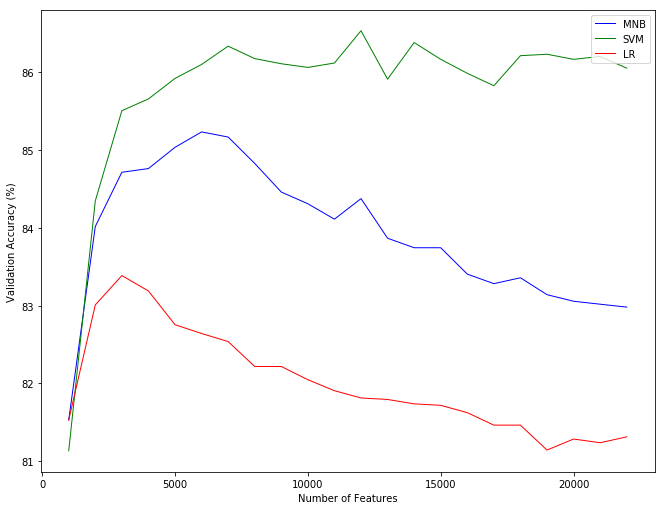

In [128]:
colors = ['blue', 'green', 'red']

data = {
    'x': [[]],
    'y': [[]]
}

data['x'] = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000]
data['y'] = [results['nb']['acc'], results['svm']['acc'], results['lr']['acc']]
print(data)
plt.plot(data['x'], data['y'][0], color=colors[0], linewidth=1)
plt.plot(data['x'], data['y'][1], color=colors[1], linewidth=1)
plt.plot(data['x'], data['y'][2], color=colors[2], linewidth=1)
#plt.plot(data['x'][2][:500], data['y'][2][:500], color="red", linewidth=1)
#plt.plot(data['x'][3][:500], data['y'][3][:500], color="green", linewidth=1)

plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy (%)')

plt.legend(['MNB', 'SVM', 'LR'], loc='upper right')

fig = plt.gcf()
fig.set_size_inches(11, 8.5, forward=True)

plt.show()
fig.savefig('numfeat')
